# Exploring Pearson correlation and sample size

Correlation skill of decadal hindcasts is very sensitive to verification period, and the commonly applied block-bootstrapping approach for estimating significance doesn't seem to work very well. This notebook explores this issue and compares a few different approaches for estimating significance.

## Assumptions of correlation:
- Normally distributed
- Homoscedastic (variance same for all values of the independent variable)
- Linear relationship
- Continuous variables
- Paired observations
- No outliers

## Inference

### 1) Boostrap

This is the "standard" approach in decadal forecast assessment

### 2) Student t-distribution

For pairs from an uncorrelated bivariate normal distribution, the sampling distribution of the studentized (sample statistic divided by a sample-based estimate standard deviation) Pearson's correlation coefficient follows Student's t-distribution with degrees of freedom n − 2. i.e.

$t = \frac{r}{\sigma_r} = r \sqrt{\frac{n - 2}{1 - r^2}}$

has a student t-distribution in the null case (this is true approximately even in case of non-normal observed values if sample sizes are large enough [1]). This can be used to determine the "critical values" of Pearson correlation coefficient that must be exceeded to be considered non-zero with a given confidence.

In the case of auto-correlated data, it is common to estimate the effective sample size and use this to estimate the critical values (e.g. [2]), though [3] have shown that it is difficult to estimate the effective sample size reliably.

### 3) Bootstrap (frequency domain)

Another documented approach is to bootstrap in the frequency domain [4]

[1] Kendall, M. G., Stuart, A. (1973) The Advanced Theory of Statistics, Volume 2: Inference and Relationship, Griffin. ISBN 0-85264-215-6 (Section 31.19)

[2] https://www.science.org/doi/full/10.1126/science.1143286

[3] https://doi.org/10.1175/1520-0450(1984)023<0800:TIAEOE>2.0.CO;2

[4] https://doi.org/10.1175/1520-0442(1997)010<2147:AMTETS>2.0.CO;2

In [8]:
import xarray as xr

from src import utils, plot, verify

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
DATA_DIR = "../../data/"

## Demonstration of sensitivity

Let's use 1-4 year SST forecasts from CanESM5 to demonstrate and explore this issue. Two different 30-year verification periods can have very different "statistically significant" correlation values (below the hatching comes from a block bootstrapping approach)

In [4]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5.4-year.anom_1985-2014.sst_global.zarr"
)

had = xr.open_zarr(
    f"{DATA_DIR}/processed/HadISST.4-year.anom_1991-2020.sst_global.zarr"
)

In [5]:
ETP_min_period = ["1984-01-01", "2013-12-31"]
ETP_max_period = ["1970-01-01", "1999-12-31"]

In [6]:
s1 = verify.calculate_metric(
    utils.keep_period(can[["sst"]], ETP_min_period),
    utils.keep_period(had[["sst"]], ETP_min_period),
    "rXY",
    significance=True,
)

s2 = verify.calculate_metric(
    utils.keep_period(can[["sst"]], ETP_max_period),
    utils.keep_period(had[["sst"]], ETP_max_period),
    "rXY",
    significance=True,
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:98: RuntimeWarning: Mean of empty slice
  ma = meanfunc(a, axis=axis)
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:99: RuntimeWarning: Mean of empty slice
  mb = meanfunc(b, axis=axis)


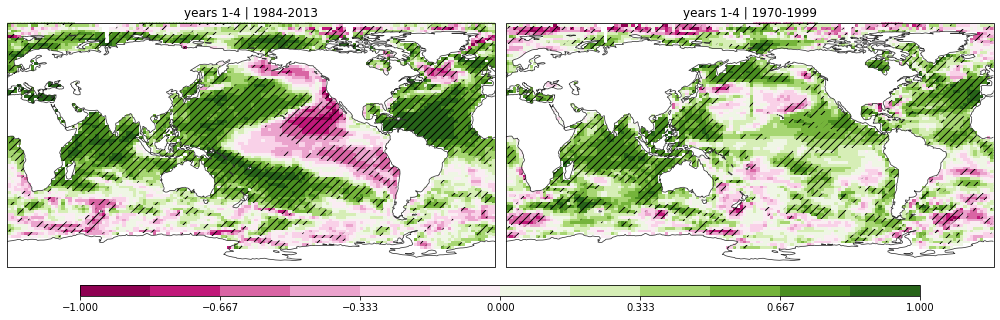

In [9]:
f = plot.metric_maps(
    [[s1.sel(lead=59).compute(), s2.sel(lead=59).compute()]],
    variable="sst",
    vrange=(-1, 1),
    headings=[["years 1-4", "years 1-4"]],
    figsize=(14, 4.2),
)

In [ ]:
can["ETP"] = utils.extract_lon_lat_box(can, ETP_box, weighted_average=True)["sst"]
had["ETP"] = utils.extract_lon_lat_box(had, ETP_box, weighted_average=True)["sst"]